C:\Users\milan\AppData\Local\Temp\ipykernel_22292\1065072038.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Year'] = filtered_data['DisNo.'].str[:4].astype(int)



Forecasting using ARIMA with Monte Carlo Simulations for the next 10 years...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2205.016, Time=2.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2286.917, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2248.811, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2203.245, Time=2.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2284.926, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2203.521, Time=1.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2203.358, Time=1.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.28 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2203.712, Time=0.69 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 11.125 seconds

Forecasted Total Damage for the Next 10 Years:
   Year  Mean Forecast  Lower 95% CI  Upper 95% CI
0  2025    3581.426255           0.0   7975.169898
1  2026    3560.059703           0.0   8145.391403
2  2027   

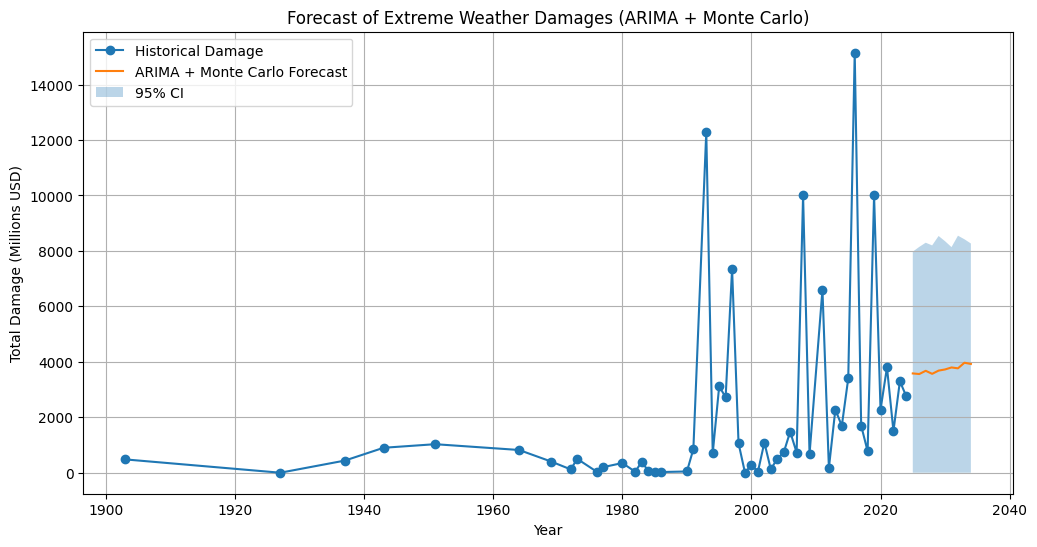

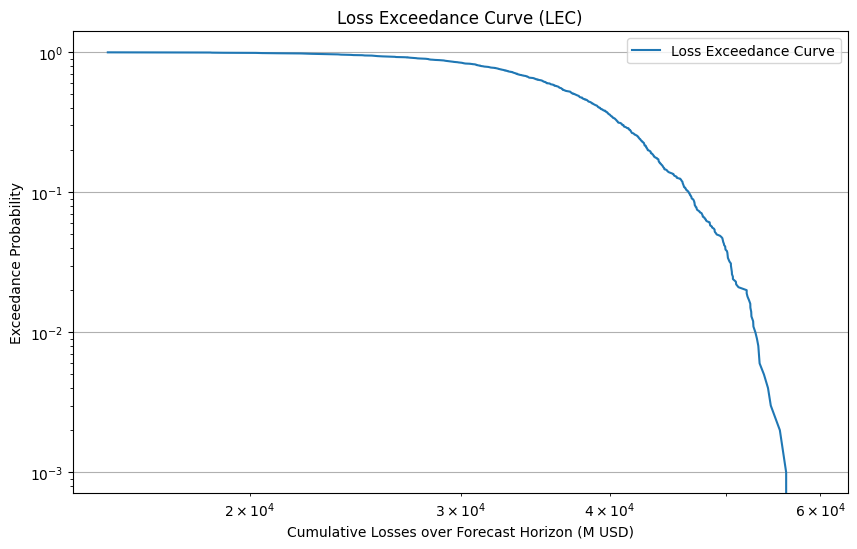

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, norm
from pmdarima import auto_arima  # Import auto_arima from pmdarima

def load_data(file_path):
    try:
        return pd.read_excel(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

def preprocess_data(data, country, disaster_type):
    filtered_data = data[(data['ISO'] == country.upper()) & 
                         (data['Disaster Type'] == disaster_type)]
    if filtered_data.empty:
        return None

    filtered_data['Year'] = filtered_data['DisNo.'].str[:4].astype(int)
    historical_data = filtered_data[['Year', 'Total Damage (\'000 US$)']].dropna()
    historical_data['Total Damage (Millions)'] = historical_data['Total Damage (\'000 US$)'] / 1_000
    historical_data = historical_data.groupby('Year').sum()
    return historical_data

def arima_monte_carlo_forecast(historical_data, forecast_years=10, num_simulations=1000):
    damage_series = historical_data['Total Damage (Millions)']
    full_years = pd.Series(index=range(damage_series.index.min(), damage_series.index.max() + 1))
    damage_series = damage_series.reindex(full_years.index, fill_value=0)

    # Use auto_arima to find the best ARIMA model based on AIC
    model = auto_arima(damage_series, seasonal=False, stepwise=True, trace=True)  # Automatically find the best order
    model_fit = model.fit(damage_series)
    forecast = model_fit.predict(n_periods=forecast_years)
    forecast_mean = forecast

    simulated_losses = []
    for _ in range(num_simulations):
        simulated_forecast = []
        for year_mean in forecast_mean:
            sim_loss = norm.rvs(loc=year_mean, scale=damage_series.std())
            simulated_forecast.append(max(sim_loss, 0))  # Ensure no negative damages
        simulated_losses.append(simulated_forecast)

    simulated_losses = np.array(simulated_losses)

    mean_forecast = simulated_losses.mean(axis=0)
    lower_bound = np.percentile(simulated_losses, 2.5, axis=0)
    upper_bound = np.percentile(simulated_losses, 97.5, axis=0)

    future_years = np.arange(historical_data.index.max() + 1, historical_data.index.max() + 1 + forecast_years)

    results = pd.DataFrame({
        'Year': future_years,
        'Mean Forecast': mean_forecast,
        'Lower 95% CI': lower_bound,
        'Upper 95% CI': upper_bound
    })

    return simulated_losses, results

def plot_forecasts(historical_data, results, simulated_losses):
    plt.figure(figsize=(12, 6))
    plt.plot(historical_data.index, historical_data['Total Damage (Millions)'], label="Historical Damage", marker='o')
    plt.plot(results['Year'], results['Mean Forecast'], label="ARIMA + Monte Carlo Forecast", linestyle='-')
    plt.fill_between(results['Year'], results['Lower 95% CI'], results['Upper 95% CI'], alpha=0.3, label="95% CI")
    plt.xlabel("Year")
    plt.ylabel("Total Damage (Millions USD)")
    plt.title("Forecast of Extreme Weather Damages (ARIMA + Monte Carlo)")
    plt.legend()
    plt.grid()
    plt.show()

    # Loss Exceedance Curve (LEC)
    total_losses = simulated_losses.sum(axis=1)
    total_losses.sort()
    plt.figure(figsize=(10, 6))
    exceedance_prob = 1 - np.arange(1, len(total_losses) + 1) / len(total_losses)
    plt.plot(total_losses, exceedance_prob, label="Loss Exceedance Curve")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Cumulative Losses over Forecast Horizon (M USD)")
    plt.ylabel("Exceedance Probability")
    plt.grid()
    plt.legend()
    plt.title("Loss Exceedance Curve (LEC)")
    plt.show()

def forecast_damage(data, country, disaster_type):
    historical_data = preprocess_data(data, country, disaster_type)
    if historical_data is None:
        print(f"No historical data available for {disaster_type} in {country}.")
        return

    print("\nForecasting using ARIMA with Monte Carlo Simulations for the next 10 years...")
    simulated_losses, results = arima_monte_carlo_forecast(historical_data)

    print("\nForecasted Total Damage for the Next 10 Years:")
    print(results)

    plot_forecasts(historical_data, results, simulated_losses)

if __name__ == "__main__":
    file_path = "All Data.xlsx"
    data = load_data(file_path)
    if data is not None:
        country = input("Enter the country (ISO code, e.g., 'USA'): ").strip().upper()
        disaster_type = input("Enter the disaster type (e.g., 'Storm'): ").strip()
        forecast_damage(data, country, disaster_type)